In [1]:
import os
from ast import literal_eval
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Introduction

# EDA

## Get the data

In [34]:
# flu data
flu_df = pd.read_csv('../data/clean_flu_data.csv')
flu_df.head()

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Nebraska,New Mexico,...,Maine,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,2.199780,2.13191,...,0.357724,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,2.735320,1.96350,...,0.434855,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,3.311030,1.67486,...,0.421743,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,2.057610,2.35498,...,0.338409,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,0.376712,2.37983,...,0.176471,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,0.971705


## Data Cleaning

## Visualization

### Flu data

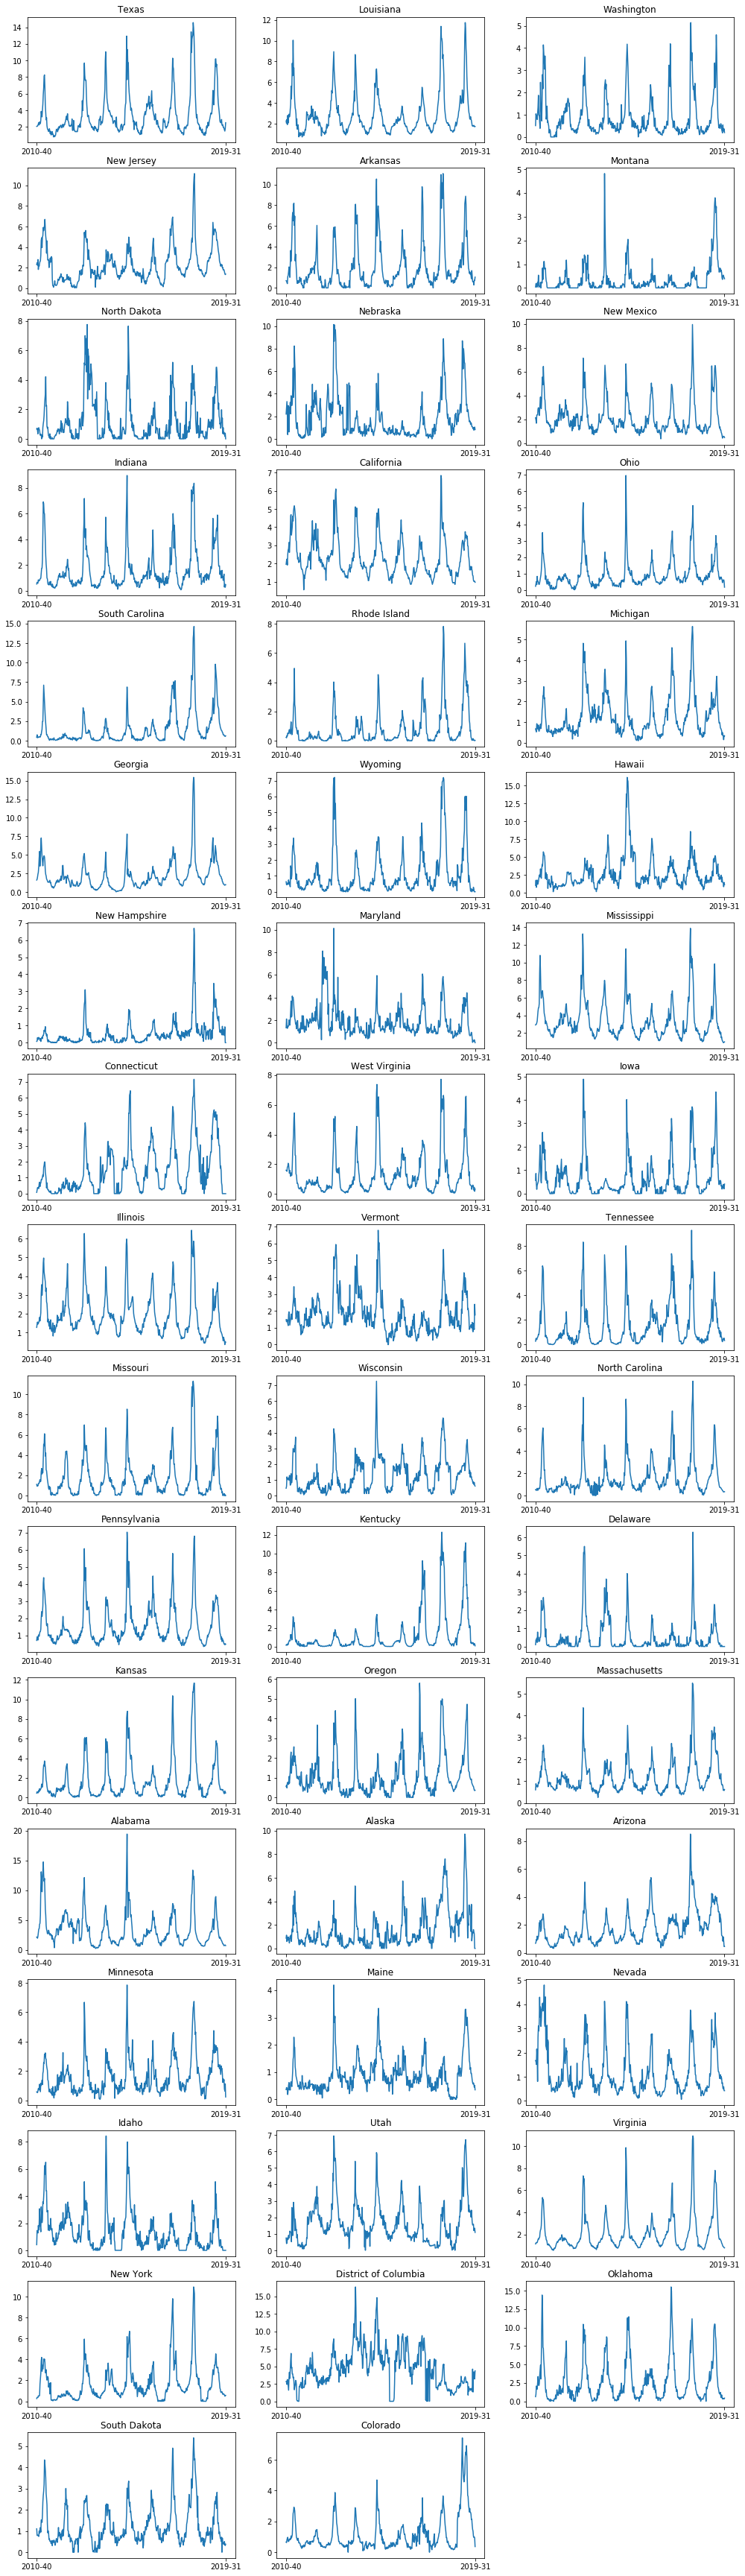

In [31]:
cols = flu_df.columns[1:]

plt.figure(figsize = (17, 100))
for i in np.arange(0, len(cols), 3):
    plt.subplot(27, 3, i+1)
    plt.plot(flu_df[cols[i]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i])
    
    plt.subplot(27, 3, i+2)
    plt.plot(flu_df[cols[i+1]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i+1])
    
    if i == 48:
        break

    plt.subplot(27, 3, i+3)
    plt.plot(flu_df[cols[i+2]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i+2])    

# Data Pre-processing

In [48]:
# ??? May be this should be somewhere else????
train_dfs, test_dfs = {}, {}
states = []
train_path = '../data/state_flu_google/train/'
test_path = '../data/state_flu_google/test/'

for root,dirs,files in os.walk(train_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            states.append(state)
            train_dfs[state] = pd.read_csv(train_path + file)

for root,dirs,files in os.walk(test_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            test_dfs[state] = pd.read_csv(test_path + file)

# Model

# Results

# Conclusion